In [1]:
%matplotlib inline
#
from lrgsglib.core import *
#
move_to_rootf(True)

Current working directory: /home/opisthofulax/PhD/projects/complex-networks/lrgsglib


In [19]:
test = pk.load(open('data/l2d_squared/lrgsg/N=4096/pCluster_p=0.103_randZERR_na=500_test01.pkl', 'rb'))

In [20]:
k,v  = unzip_dict_items(test)
arr = np.repeat(k, v)
x, pdf = powerlaw.pdf(arr, xmin=1)

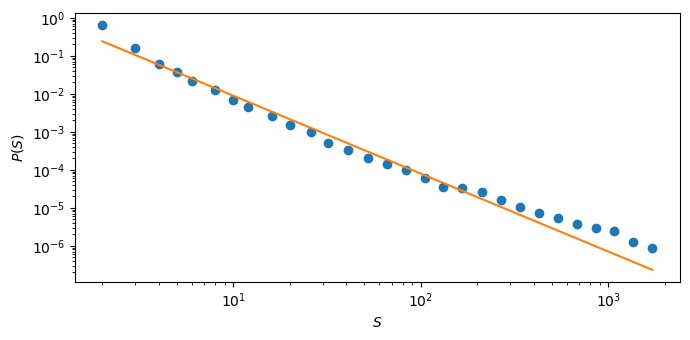

In [21]:
# plot
fig, ax = plt.subplots(figsize=(7, 3.5))
#
ax.loglog(x[1:], pdf, 'o')
ax.loglog(x[1:], x[1:]**(-2.05))
#
ax.set_xlabel(r"$S$")
ax.set_ylabel(r"$P(S)$")
#
fig.tight_layout()

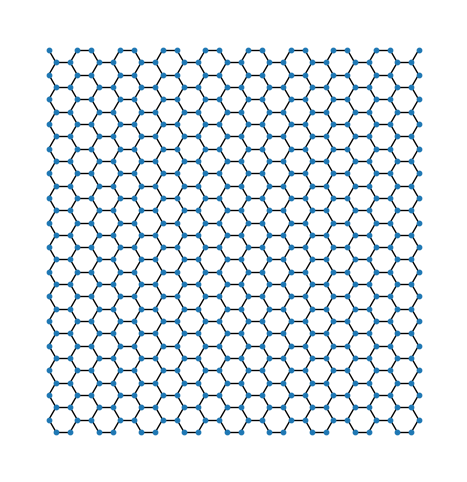

In [5]:
l = Lattice2D(32, geo='hexagonal', with_positions=True, pbc=False)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_aspect('equal')
nx.draw(l.G, ax=ax, pos=l.get_node_pos(), node_size=10, with_labels=False)

In [2]:
def eigV_for_lattice(side, **kwargs):
    l = Lattice2D(side, **kwargs)
    l.flip_random_fract_edges()
    l.compute_k_eigvV(MODE_dynspec='scipy')
    return flip_to_positive_majority(l.eigV[0])
def create_symmetric_log_bins(min_val, max_val, num_bins, incMagn = 4):
    """Creates symmetric logarithmic bins."""
    bins_positive = np.logspace(np.log10(min_val)-incMagn, np.log10(max_val)+incMagn, num_bins//2)
    bins_negative = -np.flip(bins_positive)
    return np.concatenate((bins_negative, [0], bins_positive))

def bin_eigenvalues(eig_values, bins):
    """Bins eigenvalues and counts occurrences in each bin."""
    indices = np.digitize(eig_values, bins, right=True)
    return Counter(indices)

In [31]:
# Get initial eigenvalues to define bins
initial_eig = eigV_for_lattice(side, pflip=pflip, geo=geo)
bins = create_symmetric_log_bins(np.min(np.abs(initial_eig)), np.max(np.abs(initial_eig)), bins_count)
bin_counter = Counter()

if not os.path.exists(fname):
    nAvgDone = 0
    fnameExists = glob.glob(f"{workDir}{fnameBase}*")
    if fnameExists:
        nAvgDone = int(os.path.splitext(fnameExists[0].split('_')[-1])[0])
    nAvgNeed = nAvg - nAvgDone
    fnameOld = fnameExists[0]
    for current_period in range((nAvgNeed // period) + bool(nAvgNeed % period)):
        batch_size = min(nAvgNeed - current_period * period, period)
        eig_values = np.concatenate([eigV_for_lattice(side, pflip=pflip, geo=geo) for _ in range(batch_size)])
        bin_counter.update(bin_eigenvalues(eig_values, bins))
        fnameNew = f"{workDir}{fnameBase}_{nAvgDone + (current_period + 1) * period}.pkl"
        try:
            os.rename(fnameOld, fnameNew)
        except FileNotFoundError:
            pass
        with open(fnameNew, "wb") as f:
            pk.dump(dict(bin_counter), f)
        fnameOld = f"{workDir}{fnameBase}_{nAvgDone + current_period * period}.pkl" if current_period > 0 else ""

    # At the end, save the final state if needed
    if nAvgNeed % period:
        fnameNew = f"{workDir}{fnameBase}_{nAvg}.pkl"
        with open(fnameNew, "wb") as f:
            pk.dump(dict(bin_counter), f)


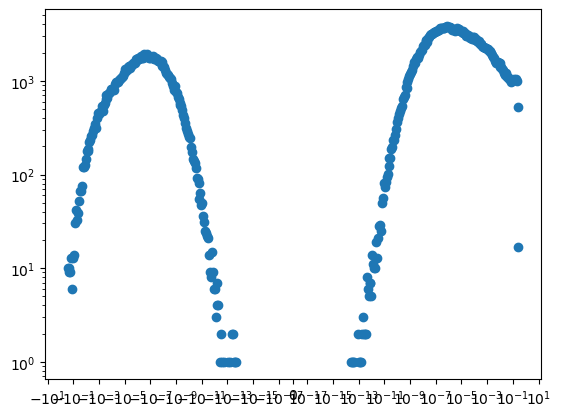

In [29]:
k,v = zip(*pk.load(open(f"{workDir}{fnameBase}_{nAvg}.pkl", "rb")).items())
binsv = bins[np.array(k)-1]
zero_index = np.where(binsv > 0)[0][0]
negative_values = v[:zero_index]
positive_values = v[zero_index:]
plt.plot(binsv, v, 'o')
# plt.axhline(np.max(positive_values))
# plt.axhline(np.max(negative_values))

plt.xscale('symlog', linthresh=1e-17)
plt.yscale('log')


In [22]:
negative_values, zero_index, np.where(binsv < 0), binsv

((),
 0,
 (array([ 23,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,
          37,  38,  42,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
          57,  58,  65,  66,  67,  68,  69,  70,  76,  78,  79,  80,  81,
          82,  83,  84,  85,  86,  87,  88,  89,  93,  94,  95,  96,  97,
          98, 103, 105, 106, 110, 111, 112, 113, 116, 120, 121, 122, 124,
         129, 130, 133, 134, 135, 138, 139, 144, 156, 162, 167, 168, 170,
         173, 174, 180, 183, 185, 187, 190, 191, 193, 194, 195, 197, 198,
         200, 201, 202, 204, 209, 210, 213, 214, 216, 217, 218, 219, 220,
         221, 222, 223, 225, 226, 228, 229, 233, 234, 235, 237, 238, 239,
         243, 244, 246, 254, 255, 256, 257, 258, 259, 260, 265, 266, 267,
         269, 270, 271, 273, 275, 276, 277, 284, 285, 287, 288, 289, 291,
         294, 295, 296, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309,
         311, 312, 314, 317, 320, 321, 325, 326, 327, 329, 330, 333, 335,
         336, 338, 340]),),
 

In [14]:
l = Lattice2D(128, pflip=0.01)
l.flip_random_fract_edges()
l.compute_k_eigvV()
outp, outm = symlog_binning(flip_to_positive_majority(l.eigV[0]))

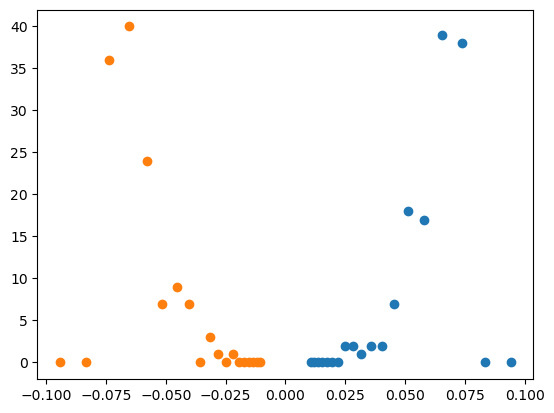

In [ ]:
plt.plot(outp[0], outp[1], 'o-')
plt.plot(outm[0], outm[1], 'o-')

In [85]:
nAvg = 1000
pflip = 0.05
side = 16
geo = 'squared'

period = 20
freq = period**(-1)
workDir = "test/"
fnameBase = "tmp"
fname = f"{workDir}{fnameBase}_{nAvg}.pkl"

if not os.path.exists(fname):
    nAvgDone = 0
    flist = os.listdir(workDir)
    fnameExists = glob.glob(f"{workDir}{fnameBase}*")
    if len(fnameExists) > 1:
        print(f"Multiple files found for {fnameBase}")
        print(fnameExists)
        exit()
    else:
        if fnameExists:
            nAvgDone = int(os.path.splitext(fnameExists[0].split('_')[-1])[0])
            print(nAvgDone)
    nAvgNeed = nAvg - nAvgDone
    #
    lEigV = []
    print(fnameExists)
    fnameOld = fnameExists[0] if nAvgDone else ""
    if nAvgNeed < period:
        lEigV = [eigV_for_lattice(side, pflip=pflip, geo=geo) 
                 for i in range(nAvgNeed)]
        fnameNew = f"{workDir}{fnameBase}_{nAvg}.pkl"
        os.rename(fnameOld, fnameNew)
        with open(fname, "ab") as f:
            pk.dump(lEigV, f)
    else:
        for _ in range(period):
            lEigV = [eigV_for_lattice(side, pflip=pflip, geo=geo) 
                    for i in range(nAvgNeed//period)]
            fnameNew = f"{workDir}{fnameBase}_{nAvgDone+(_+1)*nAvgNeed//period}.pkl"
            try:
                os.rename(fnameOld, fnameNew)
            except FileNotFoundError:
                pass
            with open(fnameNew, "ab") as f:
                pk.dump(lEigV, f)
            fnameOld = f"{workDir}{fnameBase}_{nAvgDone+(_+1)*nAvgNeed//period}.pkl"
        if nAvgNeed%period:
            lEigV = [eigV_for_lattice(side, pflip=pflip, geo=geo) 
                    for i in range(nAvgNeed%period)]
            fnameNew = f"{workDir}{fnameBase}_{nAvg}.pkl"
            with open(fnameNew, "ab") as f:
                pk.dump(lEigV, f)

# for i in range(nAvg):
#     l = Lattice2D(side, pflip=pflip)
#     l.flip_random_fract_edges()
#     l.compute_k_eigvV()
#     lEigV.append(l.eigV[0])
#     with open(fname, "ab") as f:
#         pk.dump(, f)
#         f.flush()

100
['test/tmp_100.pkl']


In [80]:
all_data = []
with open(fname, "rb") as f:
    # Loop until the end of the file
    while True:
        try:
            # Unpickle the next chunk of data and append it to the list
            data_chunk = pk.load(f)
            all_data.extend(data_chunk)
        except EOFError:
            # Reached the end of the file
            break

In [83]:
all_data

[array([-0.06440306,  0.06119091, -0.05250228,  0.04193618, -0.03532142,
         0.02976641, -0.02808946,  0.04966258, -0.07140439,  0.09055307,
        -0.10435967,  0.11101527, -0.10903023,  0.09949591, -0.08691442,
         0.07352411,  0.02958453, -0.04330919,  0.03573119, -0.02550787,
         0.03196726, -0.034114  ,  0.03686115, -0.04731914,  0.06207129,
        -0.07857539,  0.09200307, -0.10023253,  0.09743001, -0.08183839,
         0.06295745, -0.04046976, -0.0464447 ,  0.03992158, -0.01598823,
         0.0116132 , -0.02790025,  0.0324982 , -0.03212715,  0.03324262,
        -0.04122817,  0.0573215 , -0.0703811 ,  0.08472444, -0.08330214,
         0.05460458, -0.03270982,  0.04861985,  0.0603514 , -0.04766822,
         0.02582653, -0.0262465 ,  0.03113619, -0.03074245,  0.020856  ,
         0.00707002, -0.00579587, -0.03008995,  0.03641096, -0.07166268,
         0.08335378, -0.07740336,  0.06872435, -0.0672117 , -0.07059327,
         0.05707956, -0.04131951,  0.03228393, -0.0

In [ ]:
data.shape

(1024,)

In [ ]:
l = Lattice2D(side1=16,
              pflip=0.25,  
              pbc=False, 
              geo='hexagonal', 
              init_nw_dict=True, 
              with_positions=True)
l.flip_sel_edges(l.nwDict['randZERR']['G'])


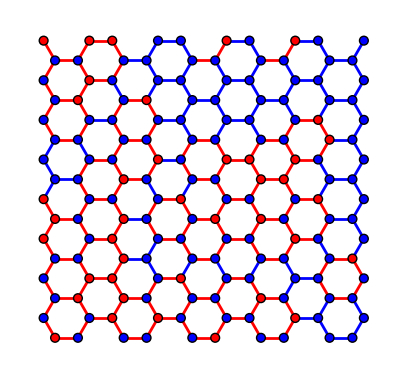

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_aspect('equal')
nx.draw(l.G, ax=ax, pos=nx.get_node_attributes(l.G, 'pos'), 
        node_size=40, 
        node_color=['red' if i in l.nwDict.rNodeFlip['G'] else 'blue' for i in l.G.nodes()],
        edgecolors='k', linewidths=1, width=2, 
        edge_color=['r' if w < 0 else 'blue' 
                    for u, v, w in list(l.G.edges(data='weight'))],
        # with_labels=True
        )